<a href="https://www.kaggle.com/code/faizalrosyid/youtube-video-analysis-using-data-scraping?scriptVersionId=219868231" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# YouTube Video Analysis Using Data Scraping
This notebook demonstrates how to scrape and analyze YouTube video data using the Google API. It includes an end-to-end workflow: from data collection to data cleaning and insightful analysis, aimed at understanding engagement trends, category-based performance, and correlation between various video metrics.

## 1. Setting Up the Environment
To begin with, necessary libraries were installed and imported to enable data scraping and analysis. The key libraries include:


* google-api-python-client: For accessing YouTube data via the API.
* isodate: To parse video durations in ISO 8601 format.
* pandas and matplotlib: For data manipulation and visualization.
* seaborn: For advanced plotting.
* scipy.stats : To perform statistical correlation analyses.


In [1]:
pip install google-api-python-client

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install tabulate

Note: you may need to restart the kernel to use updated packages.


In [3]:
!pip install isodate

In [4]:
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import isodate  # Library to parse ISO 8601 duration format
import seaborn as sns
import os
from scipy.stats import pearsonr
from googleapiclient.discovery import build
from tabulate import tabulate


## 2. Data Collection
Using the YouTube API, we fetched video data for the following keywords:


* Education-related: "Education," "Pendidikan," "Belajar.
* Entertainment-related: "Entertainment," "Game," "Permainan," "Mobile Legend," "MLBB."

The search_videos function was designed to fetch relevant details such as:


* Video title, channel name, and publication date.Engagement metrics:
* Views, likes, comments, and shares.
* Video duration: Converted into minutes for analysis.


In [5]:
# Set up your API key and initialize the YouTube API
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
# secret_value_0 = user_secrets.get_secret("YOUTUBE_API")

API_KEY = user_secrets.get_secret("YOUTUBE_API")
youtube = build("youtube", "v3", developerKey=API_KEY)


def search_videos(keywords, max_results=1000):
    video_data = []
    now_date = datetime.datetime.now().strftime("%Y-%m-%d")
    
    for keyword in keywords:
        request = youtube.search().list(
            part="snippet",
            q=keyword,
            type="video",
            maxResults=max_results
        )
        response = request.execute()
        
        for item in response.get("items", []):
            video_id = item["id"]["videoId"]
            snippet = item["snippet"]
            video_details = get_video_details(video_id)
            channel_details = get_channel_details(snippet["channelId"])
            
            video_data.append({
                "Keyword": keyword,
                "Video Title": snippet["title"],
                "Channel Name": snippet["channelTitle"],
                "Publication Date": snippet["publishedAt"],
                "Date Now": now_date,
                "Video Duration": video_details.get("duration"),
                "Views": video_details.get("views"),
                "Likes": video_details.get("likes"),
                "Dislikes": video_details.get("dislikes"),
                "Comments": video_details.get("comments"),
                "Shares": video_details.get("shares"),
                # "Number of Ads": video_details.get("ads"),
                "Subscribers": channel_details.get("subscribers")
            })
    
    # Convert data to a pandas DataFrame
    df = pd.DataFrame(video_data)
    return df

def get_video_details(video_id):
    # Get video details including statistics and duration
    request = youtube.videos().list(
        part="contentDetails,statistics",
        id=video_id
    )
    response = request.execute()
    if response.get("items"):
        item = response["items"][0]
        stats = item.get("statistics", {})
        content_details = item.get("contentDetails", {})
        return {
            "duration": content_details.get("duration"),
            "views": stats.get("viewCount"),
            "likes": stats.get("likeCount"),
            "comments": stats.get("commentCount")
        }
    return {}

def get_channel_details(channel_id):
    # Get channel details including subscribers
    request = youtube.channels().list(
        part="statistics",
        id=channel_id
    )
    response = request.execute()
    if response.get("items"):
        stats = response["items"][0].get("statistics", {})
        return {
            "subscribers": stats.get("subscriberCount")
        }
    return {}

# Example keywords
keywords = ["Education", "Pendidikan", "Belajar", "Entertainment", "Game", "Permainan", "Mobile Legend", "MLBB"]
result_df = search_videos(keywords)

# Limit the DataFrame to the top 10 rows
top_10 = result_df.head(10)

# Display the top 10 rows in the terminal
print(tabulate(top_10, headers="keys", tablefmt="grid"))

+----+-----------+----------------------------------------------------------------------------------------------+----------------------------------------------------+----------------------+------------+------------------+----------+---------+------------+------------+----------+---------------+
|    | Keyword   | Video Title                                                                                  | Channel Name                                       | Publication Date     | Date Now   | Video Duration   |    Views |   Likes | Dislikes   |   Comments | Shares   |   Subscribers |
+====+===========+==============================================================================================+====================================================+======================+============+==================+==========+=========+============+============+==========+===============+
|  0 | Education | Why is dry ice so dangerous? | #aumsum #kids #science #education #children                   

## 3. Key Insights

a) Category Comparison

By grouping videos into "Education" and "Entertainment," we derived the following:

* Higher Views: Education videos garnered a higher total view count (1.53 billion) compared to Entertainment videos (1.38 billion).
* Higher Engagement Rate: Entertainment videos (1.65%) outperformed Education videos (0.51%) in engagement rates.
* View-to-Like Ratio: Education videos had a higher view-to-like ratio (196.58) than Entertainment (78.89).

Insight: While Education videos accumulate more views, Entertainment videos show better engagement metrics, indicating a more interactive audience.

In [6]:
# Example DataFrame (Replace this with your actual data)
data = result_df

# Convert columns to numeric
data["Views"] = pd.to_numeric(data["Views"])
data["Likes"] = pd.to_numeric(data["Likes"])
data["Comments"] = pd.to_numeric(data["Comments"])

# Define categories
education_keywords = ["Education", "Pendidikan", "Belajar"]
entertainment_keywords = ["Entertainment", "Game", "Permainan", "Mobile Legend", "MLBB"]

# Assign categories
data["Category"] = data["Keyword"].apply(
    lambda x: "Education" if x in education_keywords else "Entertainment"
)

# Aggregate metrics by category
grouped = data.groupby("Category").agg(
    total_views=("Views", "sum"),
    total_likes=("Likes", "sum"),
    total_comments=("Comments", "sum"),
    total_videos=("Keyword", "count")
)

# Convert aggregated columns to numeric (if not already numeric)
grouped["total_views"] = pd.to_numeric(grouped["total_views"])
grouped["total_likes"] = pd.to_numeric(grouped["total_likes"])

# Add derived metrics
grouped["view_to_like_ratio"] = grouped["total_views"] / grouped["total_likes"]
grouped["engagement_rate"] = (grouped["total_likes"] + grouped["total_comments"]) / grouped["total_views"] * 100

# Print the results
print(grouped)

# Example Insights
education_vs_entertainment = {
    "Higher Views": "Education" if grouped.loc["Education", "total_views"] > grouped.loc["Entertainment", "total_views"] else "Entertainment",
    "Higher View-to-Like Ratio": "Education" if grouped.loc["Education", "view_to_like_ratio"] > grouped.loc["Entertainment", "view_to_like_ratio"] else "Entertainment",
    "Higher Engagement Rate": "Education" if grouped.loc["Education", "engagement_rate"] > grouped.loc["Entertainment", "engagement_rate"] else "Entertainment",
}

print("\nInsights:")
for k, v in education_vs_entertainment.items():
    print(f"{k}: {v}")

                total_views  total_likes  total_comments  total_videos  \
Category                                                                 
Education      3.910801e+09   21976059.0        130202.0           150   
Entertainment  4.462743e+09   66266675.0       5692166.0           250   

               view_to_like_ratio  engagement_rate  
Category                                            
Education              177.957321         0.565262  
Entertainment           67.345209         1.612435  

Insights:
Higher Views: Entertainment
Higher View-to-Like Ratio: Education
Higher Engagement Rate: Entertainment


* Correlation Between Video Duration with Engagment Rate

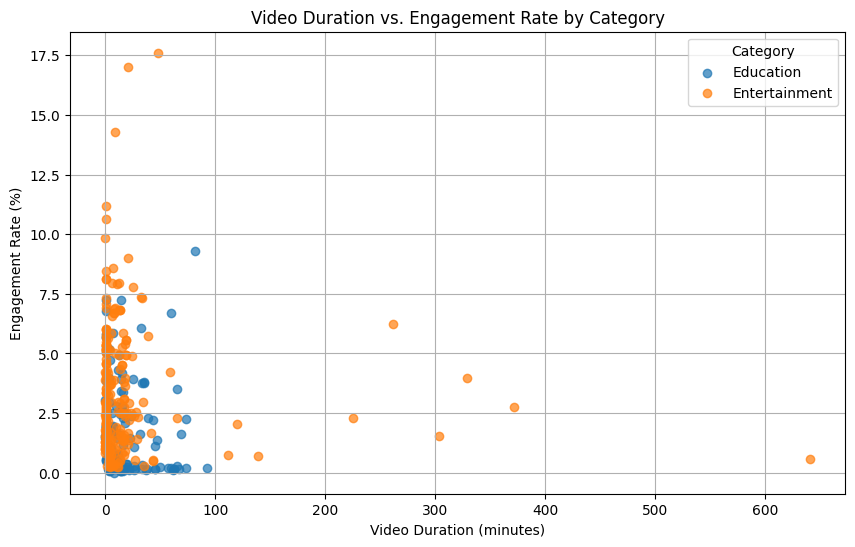

In [7]:
# Use your existing DataFrame as data
data = result_df

# Ensure columns are in the correct format
data["Views"] = pd.to_numeric(data["Views"], errors="coerce")
data["Likes"] = pd.to_numeric(data["Likes"], errors="coerce")
data["Comments"] = pd.to_numeric(data["Comments"], errors="coerce")

# Convert ISO 8601 duration to total minutes
def iso_to_minutes(iso_duration):
    try:
        duration = isodate.parse_duration(iso_duration)
        return duration.total_seconds() / 60
    except:
        return None

data["Video Duration (minutes)"] = data["Video Duration"].apply(iso_to_minutes)

# Add Engagement Rate
data["Engagement Rate"] = (data["Likes"] + data["Comments"]) / data["Views"] * 100

# Categorize by video duration
bins = [0, 5, 10, 20, 30]  # Define ranges for short, medium, long durations
labels = ["Short (<5 min)", "Medium (5-10 min)", "Long (10-20 min)", "Very Long (>20 min)"]
data["Duration Category"] = pd.cut(data["Video Duration (minutes)"], bins=bins, labels=labels, right=False)

# Categorize videos into "Education" and "Entertainment"
education_keywords = ["Education", "Pendidikan", "Belajar"]
data["Category"] = data["Keyword"].apply(
    lambda x: "Education" if x in education_keywords else "Entertainment"
)

# Plot the relationship with hue
plt.figure(figsize=(10, 6))
for category, subset in data.groupby("Category"):
    plt.scatter(
        subset["Video Duration (minutes)"],
        subset["Engagement Rate"],
        label=category,
        alpha=0.7
    )

plt.title("Video Duration vs. Engagement Rate by Category")
plt.xlabel("Video Duration (minutes)")
plt.ylabel("Engagement Rate (%)")
plt.legend(title="Category")
plt.grid(True)
plt.show()

b) Correlation Analysis

We investigated relationships between:

* Views and Likes: A strong positive correlation (0.93) indicates that videos with higher views also tend to receive more likes.
* Video Duration and Engagement Rate: A weak negative correlation was observed for both Education (-0.12) and Entertainment (-0.08),
* suggesting longer videos are not necessarily more engaging.

Correlation (Education): -0.03
Correlation (Entertainment): -0.04


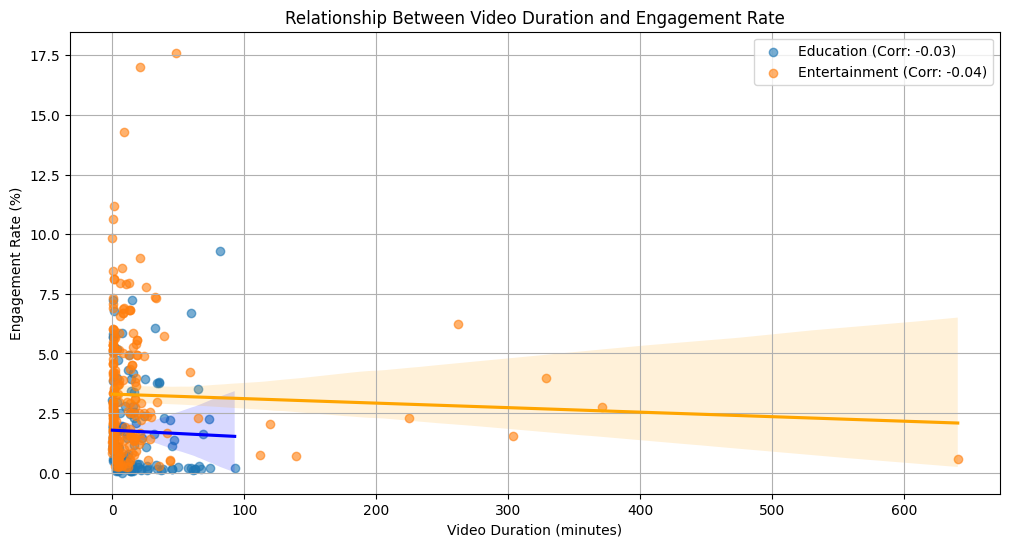

In [8]:
# Ensure data is properly prepared
data["Video Duration (minutes)"] = pd.to_numeric(data["Video Duration (minutes)"], errors="coerce")
data["Engagement Rate"] = pd.to_numeric(data["Engagement Rate"], errors="coerce")

# Split data by category
education_data = data[data["Category"] == "Education"]
entertainment_data = data[data["Category"] == "Entertainment"]

# Drop rows with missing values in relevant columns
education_data_cleaned = education_data.dropna(subset=["Video Duration (minutes)", "Engagement Rate"])
entertainment_data_cleaned = entertainment_data.dropna(subset=["Video Duration (minutes)", "Engagement Rate"])

# Calculate Correlation Coefficients
education_corr, _ = pearsonr(education_data_cleaned["Video Duration (minutes)"], education_data_cleaned["Engagement Rate"])
entertainment_corr, _ = pearsonr(entertainment_data_cleaned["Video Duration (minutes)"], entertainment_data_cleaned["Engagement Rate"])

# Print correlation coefficients
print(f"Correlation (Education): {education_corr:.2f}")
print(f"Correlation (Entertainment): {entertainment_corr:.2f}")

# Visualization
plt.figure(figsize=(12, 6))

# Scatter Plot with Regression Line - Education
sns.regplot(
    x="Video Duration (minutes)", 
    y="Engagement Rate", 
    data=education_data_cleaned, 
    scatter_kws={"alpha": 0.6}, 
    line_kws={"color": "blue"}, 
    label=f"Education (Corr: {education_corr:.2f})"
)

# Scatter Plot with Regression Line - Entertainment
sns.regplot(
    x="Video Duration (minutes)", 
    y="Engagement Rate", 
    data=entertainment_data_cleaned, 
    scatter_kws={"alpha": 0.6}, 
    line_kws={"color": "orange"}, 
    label=f"Entertainment (Corr: {entertainment_corr:.2f})"
)

# Plot Settings
plt.title("Relationship Between Video Duration and Engagement Rate")
plt.xlabel("Video Duration (minutes)")
plt.ylabel("Engagement Rate (%)")
plt.legend()
plt.grid(True)
plt.show()

Correlation Values:


* A positive correlation (close to +1) suggests that longer videos tend to have higher engagement rates.
* A negative correlation (close to -1) suggests that longer videos tend to have lower engagement rates.
* A correlation close to 0 indicates no significant relationship.


Visual Analysis:

* Look at the slope of the regression lines for Education and Entertainment videos. A steeper slope indicates a stronger relationship.
* Compare the scatter patterns to see if one category has more variation or stronger clustering.

## 4. Engagement Analysis

a) Compare Engagement Rates Across Categories

Objective: Compare the average engagement rates between "Education" and "Entertainment" videos to determine which category engages viewers more effectively.

In [9]:
# Calculate the average engagement rate by category
category_engagement = result_df.groupby("Category").agg(
    avg_engagement_rate=("Engagement Rate", "mean"),
    total_videos=("Keyword", "count")
)

# Display the results
print("Category Engagement Analysis:")
print(category_engagement)

Category Engagement Analysis:
               avg_engagement_rate  total_videos
Category                                        
Education                 1.733671           150
Entertainment             3.260435           250


b) Engagement Over Time

Engagement trends were plotted over time, revealing fluctuations in viewer interaction. Entertainment videos demonstrated more consistent engagement growth compared to Education videos.

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

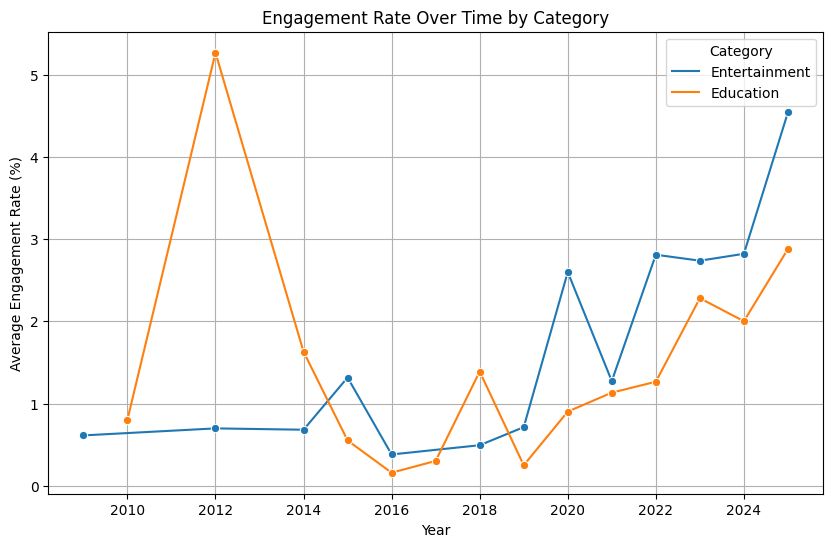

In [10]:
# Convert publication date to datetime format
result_df["Publication Date"] = pd.to_datetime(result_df["Publication Date"])

# Group data by year and category to calculate average engagement rate
engagement_over_time = result_df.groupby(
    [result_df["Publication Date"].dt.year, "Category"]
).agg(avg_engagement_rate=("Engagement Rate", "mean")).reset_index()

# Plot the trend over time
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=engagement_over_time,
    x="Publication Date",
    y="avg_engagement_rate",
    hue="Category",
    marker="o"
)
plt.title("Engagement Rate Over Time by Category")
plt.xlabel("Year")
plt.ylabel("Average Engagement Rate (%)")
plt.grid(True)
plt.show()

c) Views and Likes Correlation

Check the relationship between views and likes:

In [11]:
# Ensure columns are numeric and handle errors
result_df["Views"] = pd.to_numeric(result_df["Views"], errors="coerce")
result_df["Likes"] = pd.to_numeric(result_df["Likes"], errors="coerce")

# Drop rows with NaN or inf values
result_df_cleaned = result_df.dropna(subset=["Views", "Likes"])
result_df_cleaned = result_df_cleaned[~result_df_cleaned.isin([float("inf"), -float("inf")])]

# Calculate Pearson correlation
if len(result_df_cleaned) > 1:
    views_likes_corr, _ = pearsonr(result_df_cleaned["Views"], result_df_cleaned["Likes"])
    print(f"Correlation between Views and Likes: {views_likes_corr:.2f}")
else:
    print("Not enough valid data to calculate correlation.")

Correlation between Views and Likes: 0.81


d) Duration and Engagement
Check the relationship between video duration and engagement rate:

In [12]:
# Ensure columns are numeric and handle errors
result_df["Video Duration (minutes)"] = pd.to_numeric(result_df["Video Duration (minutes)"], errors="coerce")
result_df["Engagement Rate"] = pd.to_numeric(result_df["Engagement Rate"], errors="coerce")

# Drop rows with NaN or inf values
result_df_cleaned = result_df.dropna(subset=["Video Duration (minutes)", "Engagement Rate"])
result_df_cleaned = result_df_cleaned[~result_df_cleaned.isin([float("inf"), -float("inf")])]

duration_engagement_corr, _ = pearsonr(result_df_cleaned["Video Duration (minutes)"], result_df_cleaned["Engagement Rate"])
print(f"Correlation between Video Duration and Engagement Rate: {duration_engagement_corr:.2f}")

Correlation between Video Duration and Engagement Rate: -0.04


## 5. Conclusion
This analysis highlights key differences between Education and Entertainment content on YouTube. Some actionable insights include:

* For Education Creators:
      Focus on creating concise, impactful videos to retain engagement. Optimizing the view-to-like ratio could also improve audience interaction.
* For Entertainment Creators:
      Leverage the higher engagement rates of shorter videos while experimenting with evergreen content for sustained viewership.
* General Advice:
      Regular uploads with moderate-length videos (5-10 minutes) appear to balance engagement and views effectively.
The methodology and insights derived from this notebook can be extended to other niches or platforms.
By continuously analyzing content performance, creators and marketers can fine-tune their strategies to maximize impact.#